In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#Only do this once!
!pip install pretrainedmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 1.6 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=65f48b28689b886b4f8c555435cc59a917a16b38db321d4d5121263782c7e0af
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built pretrainedmodels


In [3]:
#Only do this once!
# !powershell -command "Expand-Archive C:\Users\alexa\Documents\GitHub\bridging_domain_gap\train_data\dataset_1000.zip C:\Users\alexa\Documents\GitHub\bridging_domain_gap\train_data\dataset_1000"
!unzip "/content/gdrive/MyDrive/train_data/dataset_1000.zip"

Archive:  /content/gdrive/MyDrive/train_data/dataset_1000.zip
 extracting: 000000.png              
 extracting: 000000_seg.png          
 extracting: 000000_ldmks.txt        
 extracting: 000001.png              
 extracting: 000001_seg.png          
 extracting: 000001_ldmks.txt        
 extracting: 000002.png              
 extracting: 000002_seg.png          
 extracting: 000002_ldmks.txt        
 extracting: 000003.png              
 extracting: 000003_seg.png          
 extracting: 000003_ldmks.txt        
 extracting: 000004.png              
 extracting: 000004_seg.png          
 extracting: 000004_ldmks.txt        
 extracting: 000005.png              
 extracting: 000005_seg.png          
 extracting: 000005_ldmks.txt        
 extracting: 000006.png              
 extracting: 000006_seg.png          
 extracting: 000006_ldmks.txt        
 extracting: 000007.png              
 extracting: 000007_seg.png          
 extracting: 000007_ldmks.txt        
 extracting: 000008.png   

In [4]:
#install weights and biases for data logging
!pip install wandb
!wandb login a4bcc50b82d76b731f260317595bd29e48e045a5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.0 MB/s 
     |████████████████████████████████| 168 kB 38.7 MB/s 
     |████████████████████████████████| 182 kB 44.2 MB/s 
     |████████████████████████████████| 62 kB 883 kB/s 
     |████████████████████████████████| 168 kB 42.2 MB/s 
     |████████████████████████████████| 166 kB 48.0 MB/s 
     |████████████████████████████████| 166 kB 10.1 MB/s 
     |████████████████████████████████| 162 kB 49.2 MB/s 
     |████████████████████████████████| 162 kB 32.5 MB/s 
     |████████████████████████████████| 158 kB 46.5 MB/s 
     |████████████████████████████████| 157 kB 16.7 MB/s 
     |████████████████████████████████| 157 kB 50.3 MB/s 
     |████████████████████████████████| 157 kB 45.6 MB/s 
     |████████████████████████████████| 157 kB 47.3 MB/s 
     |████████████████████████████████| 157 kB 50.9 MB/s 
     |████████████████████████████

In [5]:
#time all processes to measure network efficiency
#only install once!
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.5 MB/s 
time: 657 µs (started: 2022-12-03 00:37:37 +00:00)


**Imports**

In [6]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pretrainedmodels
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.optim as one
import matplotlib
from tqdm import tqdm
from torchvision import transforms
import wandb
import random
from PIL import Image, ImageFilter

time: 9.87 s (started: 2022-12-03 00:37:37 +00:00)


**Config**

In [7]:
#paths
#TEST_ROOT_PATH = "C:/Users/alexa/Documents/GitHub/bridging_domain_gap/300w/300W"
TEST_ROOT_PATH = '/content/gdrive/MyDrive/300W'
#TRAIN_ROOT_PATH = "C:/Users/alexa/Documents/GitHub/bridging_domain_gap/train_data/dataset_10000/dataset_10000"
TRAIN_ROOT_PATH = '/content'
# hyperparameters
BATCH_SIZE = 8 #could try smaller batch size. If model is still improving in last epoch this can be increased.
LR = 1e-3
EPOCHS = 50
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# train/test split
TEST_SPLIT = 0.1 #for testing without training we want to test on most of the data
# show dataset keypoint plot
SHOW_DATASET_PLOT = True
RANDOM_SEED=42

time: 117 ms (started: 2022-12-03 00:37:47 +00:00)


**Augmentation**

In [8]:
class Config():
    def __init__(self):
        self.input_size = 244
        self.experiment_name = None

cfg = Config()
cfg.experiment_name = "01"

# Augmentation methods:
def random_translate(image, target, override = False):

    if override == True or random.random() > 0.5:
        image_height, image_width = image.size
        a = 1
        b = 0
        #c = 30 #left/right (i.e. 5/-5)
        c = int((random.random()-0.5) * 60)
        d = 0
        e = 1
        #f = 30 #up/down (i.e. 5/-5)
        f = int((random.random()-0.5) * 60)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))
        target_translate = target.copy()
        target_translate = target_translate.reshape(-1, 2)
        target_translate[:, 0] -= 1.*c/image_width
        target_translate[:, 1] -= 1.*f/image_height
        target_translate = target_translate.flatten()
        target_translate[target_translate < 0] = 0
        target_translate[target_translate > 1] = 1
        return image, target_translate
    else:
        return image, target

def random_blur(image, override = False):
    if override == True or random.random() > 0.7:
        image = image.filter(ImageFilter.GaussianBlur(random.random()*5))
    return image


def random_occlusion(image, override = False):
    if override == True or random.random() > 0.5:
        image_np = np.array(image).astype(np.uint8)
        image_np = image_np[:,:,::-1]
        image_height, image_width, _ = image_np.shape
        occ_height = int(image_height*0.4*random.random())
        occ_width = int(image_width*0.4*random.random())
        occ_xmin = int((image_width - occ_width - 10) * random.random())
        occ_ymin = int((image_height - occ_height - 10) * random.random())
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 0] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 1] = int(random.random() * 255)
        image_np[occ_ymin:occ_ymin+occ_height, occ_xmin:occ_xmin+occ_width, 2] = int(random.random() * 255)
        image_pil = Image.fromarray(image_np[:,:,::-1].astype('uint8'), 'RGB')
        return image_pil
    else:
        return image

def random_rotate(image, target, angle_max, override = False):
    if override == True or random.random() > 0.5:
        center_x = 0.5
        center_y = 0.5
        landmark_num= int(len(target) / 2)
        target_center = np.array(target) - np.array([center_x, center_y]*landmark_num)
        target_center = target_center.reshape(landmark_num, 2)
        theta_max = np.radians(angle_max)
        theta = random.uniform(-theta_max, theta_max)
        angle = np.degrees(theta)
        image = image.rotate(angle)

        c, s = np.cos(theta), np.sin(theta)
        rot = np.array(((c,-s), (s, c)))
        target_center_rot = np.matmul(target_center, rot)
        target_rot = target_center_rot.reshape(landmark_num*2) + np.array([center_x, center_y]*landmark_num)
        return image, target_rot
    else:
        return image, target

time: 19.8 ms (started: 2022-12-03 00:37:47 +00:00)


**Utility**

In [60]:
def valid_keypoints_plot(image, outputs, orig_keypoints, epoch=0):
    """
    This function plots the regressed (predicted) keypoints and the actual
    keypoints after each validation epoch for one image in the batch.
    """
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    outputs = outputs.detach().cpu().numpy()
    orig_keypoints = orig_keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    output_keypoint = outputs[0]
    orig_keypoint = orig_keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)

    output_keypoint = output_keypoint.reshape(-1, 2)
    orig_keypoint = orig_keypoint.reshape(-1, 2)
    for p in range(output_keypoint.shape[0]):
        plt.plot(output_keypoint[p, 0], output_keypoint[p, 1], 'r.')
        plt.plot(orig_keypoint[p, 0], orig_keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def image_keypoints_plot(image, keypoints):
    # detach the image, keypoints, and output tensors from GPU to CPU
    image = image.detach().cpu()
    keypoints = keypoints.detach().cpu().numpy()
    # just get a single datapoint from each batch
    img = image[0]
    keypoint = keypoints[0]
    img = np.array(img, dtype='float32')
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    keypoint = keypoint.reshape(-1, 2)
    for p in range(keypoint.shape[0]):
        plt.plot(keypoint[p, 0], keypoint[p, 1], 'b.')
    plt.show()
    # plt.close()

def dataset_keypoints_plot(data):
    """
    This function shows the image faces and keypoint plots that the model
    will actually see. This is a good way to validate that our dataset is in
    fact correct and the faces align with the keypoint features. The plot
    will be show just before training starts. Press `q` to quit the plot and
    start training.
    """
    plt.figure(figsize=(10, 10))
    for i in range(9):
        sample = data[i]
        img = sample['image']
        img = np.array(img, dtype='float32')
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        keypoints = sample['keypoints']
        for j in range(len(keypoints)):
            plt.plot(keypoints[j, 0], keypoints[j, 1], 'b.')
    plt.show()
    plt.close()


time: 4.95 ms (started: 2022-12-03 01:11:48 +00:00)


**Dataset Class**

In [76]:
def train_test_split(folder_path, split):
  im_list = np.array([])
  for f in os.listdir(folder_path):
    if not '_seg' in f and not '_ldmks' in f and '.png' in f:
      im_list = np.append(im_list, f)
  len_data = len(im_list)
  # calculate the validation data sample length
  valid_split = int(len_data * split)
  # calculate the training data samples length
  train_split = int(len_data - valid_split)
  training_samples = im_list[:train_split]
  valid_samples = im_list[-valid_split:]
  return training_samples, valid_samples

def get_keypoints(file_name):
  #remove file extension from file_name
  idx = [idx for idx, x in enumerate(file_name) if x == '.']
  file_name = file_name[:idx[0]]
  #get name of keypoint file
  file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
  #fetch file and extract keypoints as list of tuples
  keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
  keypoints = np.array(keypoints, dtype='float32')
  return keypoints

class FaceKeypointTrainDataset(Dataset):
    def __init__(self, samples, path):
        self.data = samples
        self.path = path
        self.resize = 224
        #normalization required for pretrained pytorch networks
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.transform = transforms.Compose([transforms.RandomGrayscale(0.2),
                                             transforms.Resize(cfg.input_size),
                                             transforms.ToTensor(),
                                             normalize])

    def __len__(self):
        return len(self.data)

    def get_keypoints(self, file_name):
        #remove file extension from file_name
        idx = [idx for idx, x in enumerate(file_name) if x == '.']
        file_name = file_name[:idx[0]]
        #get name of keypoint file
        file_name = TRAIN_ROOT_PATH +  "/" + file_name + "_ldmks.txt"
        #fetch file and extract keypoints as list of tuples
        keypoints = pd.read_csv(file_name, sep=" ", header=None, names=range(1,3))
        keypoints = np.array(keypoints, dtype='float32')
        return keypoints

    def __getitem__(self, index):
        image = Image.open(f"{self.path}/{self.data[index]}").convert('RGB')
        orig_w, orig_h = image.size
        # get the keypoints
        keypoints = self.get_keypoints(self.data[index])
        #do keypoint preprocessing:
        keypoints = keypoints/512
        keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
        keypoints = keypoints[:,0]
        # apply data augmentation
        #rotate image
        image, keypoints = random_rotate(image, keypoints, 30, True)
        keypoints = np.reshape(keypoints,(len(keypoints)//2, 2))
        #translate image
        image, keypoints = random_translate(image, keypoints, True)
        keypoints = np.reshape(keypoints,(len(keypoints)//2, 2))
        #add occlusion
        image = random_occlusion(image, True)
        #add blur
        image = random_blur(image, True)
        image = self.transform(image)
        # reshape the keypoints
        keypoints = keypoints.reshape(-1, 2)
        # rescale keypoints according to image resize
        keypoints = keypoints * [cfg.input_size, cfg.input_size]
        return {
            'image': image,
            'keypoints': torch.tensor(keypoints, dtype=torch.float),
        }

class FaceKeypointTestDataset(Dataset):
    def __init__(self, path):
      ind_names = np.array([])
      out_names = np.array([])
      for f in os.listdir(path + "/01_Indoor"):
        if not '.pts' in f:
          ind_names = np.append(ind_names, "/01_Indoor/" + f)
      for f in os.listdir(path + "/02_Outdoor"):
        if not '.pts' in f:
          out_names = np.append(out_names, '/02_Outdoor/' + f)
      self.ind_data = ind_names
      self.out_data = out_names
      self.path = path
      self.resize = 224
      #normalization required for pretrained pytorch networks
      self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.data)

    def get_300W_item(self, name):
      pathname = self.path + name
      image = cv2.imread(pathname)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      orig_h, orig_w, channel = image.shape
      # resize the image into `resize` defined above
      image = cv2.resize(image, (self.resize, self.resize))
      # again reshape to add grayscale channel format
      image = image / 255.0
      # transpose for getting the channel size to index 0
      image = np.transpose(image, (2, 0, 1))
      image = torch.tensor(image, dtype=torch.float)
      image = self.normalize(image)
      # get the keypoints
      idx = [idx for idx, x in enumerate(pathname) if x == '.']
      keyname = pathname[0:idx[0]] + ".pts"
      keypoints = np.loadtxt(keyname, dtype=float, comments=("version:", "n_points:", "{", "}"))
      # reshape the keypoints
      keypoints.reshape(68, 2)
      # rescale keypoints according to image resize
      keypoints = keypoints * [self.resize / orig_w, self.resize / orig_h]
      return image, torch.tensor(keypoints,dtype=torch.float)

    def get_300W_Data(self):
      np.random.seed(RANDOM_SEED)
      np.random.shuffle(self.ind_data)
      np.random.shuffle(self.out_data)
      #use a randomized 500 ims from outdoor images and a randomized 500 from indoor images
      data = np.append(self.ind_data[0:500], self.out_data[0:500])
      return data

time: 11.2 ms (started: 2022-12-03 01:33:20 +00:00)


**Setup Data**

Training sample instances: 900
Validation sample instances: 100


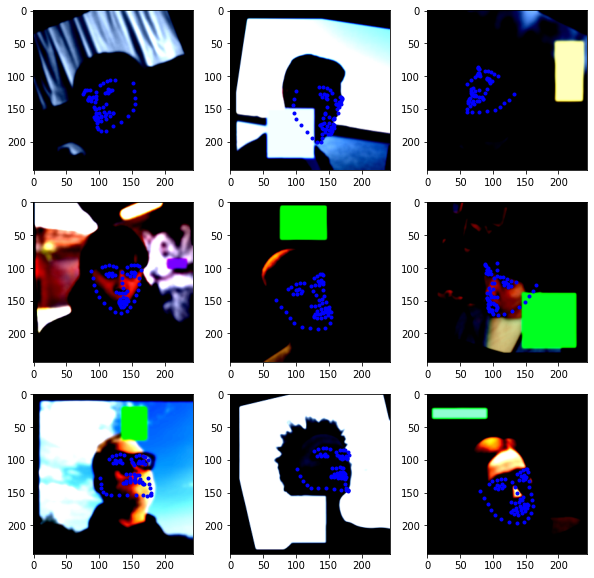

time: 2.54 s (started: 2022-12-03 01:33:24 +00:00)


In [77]:
# get the training and validation data samples
training_samples, valid_samples = train_test_split(f"{TRAIN_ROOT_PATH}", TEST_SPLIT)
# initialize the dataset - `FaceKeypointDataset()`
train_data = FaceKeypointTrainDataset(training_samples, f"{TRAIN_ROOT_PATH}")
valid_data = FaceKeypointTrainDataset(valid_samples, f"{TRAIN_ROOT_PATH}")
# prepare data loaders
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
valid_loader = DataLoader(valid_data,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print(f"Training sample instances: {len(train_data)}")
print(f"Validation sample instances: {len(valid_data)}")

# whether to show dataset keypoint plots
if SHOW_DATASET_PLOT:
    dataset_keypoints_plot(valid_data)


<PIL.Image.Image image mode=RGB size=244x244 at 0x7F3942ABA490>


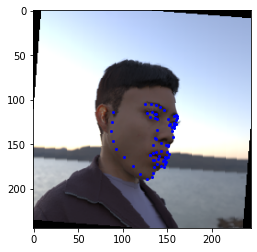

<PIL.Image.Image image mode=RGB size=244x244 at 0x7F394277B750>


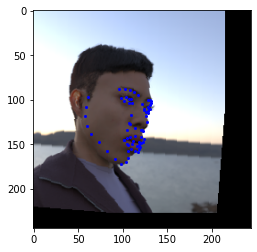

<PIL.Image.Image image mode=RGB size=244x244 at 0x7F393F0CFAD0>


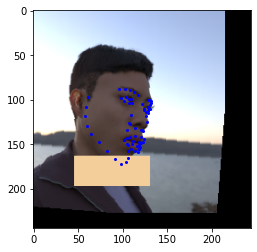

<PIL.Image.Image image mode=RGB size=244x244 at 0x7F394280ED10>


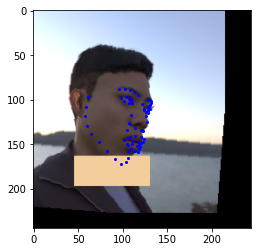

time: 852 ms (started: 2022-12-03 01:22:31 +00:00)


In [68]:

# test data augmentation

image_path = "000185.png"
image = Image.open("/content/" + image_path)
image = image.resize((cfg.input_size, cfg.input_size))

orig_keypoints = get_keypoints(image_path)
keypoints = orig_keypoints/512
keypoints = np.reshape(keypoints, (keypoints.shape[0]*2, 1))
keypoints = keypoints[:,0]

image_augmented, target = random_rotate(image, keypoints, 30, True)
target = np.reshape(target,(len(target)//2, 2))
print(image_augmented)
plt.imshow(image_augmented)
plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
plt.show()

image_augmented, target = random_translate(image_augmented, target, True)
target = np.reshape(target,(len(target)//2, 2))
print(image_augmented)
plt.imshow(image_augmented)
plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
plt.show()

image_augmented = random_occlusion(image_augmented, True)
print(image_augmented)
plt.imshow(image_augmented)
plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
plt.show()

image_augmented = random_blur(image_augmented, True)
print(image_augmented)
plt.imshow(image_augmented)
plt.plot(target[:,0]*cfg.input_size,target[:,1]*cfg.input_size, 'bo', markersize=2)
plt.show()


**Model Class**

In [78]:
class FaceKeypointResNet50(nn.Module):
    def __init__(self, pretrained, requires_grad):
        super(FaceKeypointResNet50, self).__init__()
        if pretrained == True:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet50'](pretrained=None)
        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
            print('Training intermediate layer parameters...')
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False
            print('Freezing intermediate layer parameters...')
        # change the final layer
        self.l0 = nn.Linear(2048, 140)

    def forward(self, x):
        # get the batch size only, ignore (c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        l0 = self.l0(x)
        return l0

time: 4.26 ms (started: 2022-12-03 01:35:11 +00:00)


**Training**

In [79]:
def compute_nme(preds, target):
    """ preds/target:: numpy array, shape is (N, L, 2)
        N: batchsize L: num of landmark
    """
    preds = preds.cuda().detach().cpu().clone().numpy()
    target = target.cuda().detach().cpu().clone().numpy()

    preds = preds[:, 0:136]

    N = preds.shape[0]
    preds = np.reshape(preds, (N, 68, 2))
    L = preds.shape[1]
    L_targ = target.shape[1]

    if L_targ == 140:
      target = target[:, 0:136]
    target = np.reshape(target, (N, 68, 2))

    rmse = np.zeros(N)

    for i in range(N):
        pts_pred, pts_gt = preds[i, ], target[i, ]
        if L == 68:  # 300w
            # interocular
            interocular = np.linalg.norm(pts_gt[36, ] - pts_gt[45, ])
        else:
            raise ValueError('Number of landmarks is wrong')
        rmse[i] = np.sum(np.linalg.norm(pts_pred - pts_gt,
                                        axis=1)) / (interocular * L)

    return np.mean(rmse)

matplotlib.style.use('ggplot')
#model
#NOTE: setting pretrained=True and requires_grad=True initializes our weights with pretrained model and then updates our intermediate layers
model = FaceKeypointResNet50(pretrained=True, requires_grad=True).to(DEVICE)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)
# we need a loss function which is good for regression like SmoothL1Loss ...
# ... or MSELoss
criterion = nn.MSELoss()

# training function
def fit(model, dataloader, data):
    print('Training')
    model.train()
    train_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i, data in tqdm(enumerate(dataloader), total=num_batches):
        counter += 1
        image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
        # flatten the keypoints
        keypoints = keypoints.view(keypoints.size(0), -1)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, keypoints)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = train_running_loss/counter
    return train_loss

# validatioon function
def validate(model, dataloader, data, epoch):
    print('Validating')
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # calculate the number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=num_batches):
            counter += 1
            image, keypoints = data['image'].to(DEVICE), data['keypoints'].to(DEVICE)
            # flatten the keypoints
            keypoints = keypoints.view(keypoints.size(0), -1)
            outputs = model(image)
            loss = criterion(outputs, keypoints)
            nme = compute_nme(outputs, keypoints)
            valid_running_loss += loss.item()
            # plot the predicted validation keypoints after every...
            # ... predefined number of epochs\
            if (epoch+1) % 1 == 0 and i == 0:
                valid_keypoints_plot(image, outputs, keypoints, epoch)
            if epoch+1 == EPOCHS:
                valid_keypoints_plot(image, outputs, keypoints, epoch)

    valid_loss = valid_running_loss/counter
    return valid_loss, nme

# Do training and validation

wandb.init(project="resnet50_domain_gap")
wandb.config = {
  "learning_rate": LR,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE
}
wandb.watch(model, criterion, log="all", log_freq=1) #TODO might want to change log_freq?

best_val_loss = 1000
# Want to test without training: do validation for a small number of epochs
train_loss = []
val_loss = []
nme = []
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_loader, train_data)
    val_epoch_loss, nme_val = validate(model, valid_loader, valid_data, epoch)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    nme.append(nme_val)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')
    print(f'NME: {nme_val:.4f}')
    wandb.log({"epoch": (epoch+1),
               "train_loss": (train_epoch_loss),
               "val_loss": (val_epoch_loss),
               "NME": (nme_val)})
    wandb.define_metric("epoch")
    if val_epoch_loss < best_val_loss:
      best_val_loss = val_epoch_loss
      torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'C:/Users/alexa/Documents/GitHub/bridging_domain_gap/resnet50_1000.pt')


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.plot(nme, color='blue', label='NME')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print('DONE TRAINING')


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Training intermediate layer parameters...


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alexmountain. Use `wandb login --relogin` to force relogin


Epoch 1 of 50
Training


  0%|          | 0/112 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

time: 11.9 s (started: 2022-12-03 01:35:15 +00:00)


**Testing Phase**

In [ ]:
#Run model on test data from 300WLPA dataset and report NME

#model.load_state_dict(torch.load('sample_data/resnet50_1000.pt')['model_state_dict'])
testdata = FaceKeypointTestDataset(TEST_ROOT_PATH)
dataframe = testdata.get_300W_Data()
nme = []
count = 0
for n in dataframe:
  image, keypoints = testdata.get_300W_item(n)
  image = torch.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))
  image = image.to(DEVICE)
  keypoints = torch.reshape(keypoints, (1, keypoints.shape[0], keypoints.shape[1]))
  outputs = model(image)
  outputs = outputs[:, 0:136]
  if count % 20 == 0:
    valid_keypoints_plot(image, outputs, keypoints)
  nme_val = compute_nme(outputs, keypoints)
  print(nme_val)
  nme.append(nme_val)
  count += 1


nme = np.array(nme)
print("Average NME: " + str(np.mean(nme)))

**Video Integration**

If this doesn't work in colab then run it locally by downloading the model after training

(download will take a while unfortunately).

You will also require the above code that handles hyperparameter configuration and the code that defines our model class

In [ ]:
# #Imports required for running video locally:
# import torch
# import torch.nn as nn
# import numpy as np
# import cv2
# from torchvision import transforms
# import pretrainedmodels

In [ ]:
# model = FaceKeypointResNet50(pretrained=False, requires_grad=False).to(DEVICE)
# # checkpoint = torch.load('sample_data/my_model_1000.pt')
# # model.load_state_dict(checkpoint['model_state_dict'])
# # model.eval()

# #capture the webcam
# cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
# if cap.isOpened()==False:
#   print('Error while trying to open webcam. Please check again...')

# # get the frame width and height
# frame_width = int(cap.get(3))
# frame_height = int(cap.get(4))

# # set up the save file path
# save_path = "sample_data/vid_keypoint_detection.mp4"
# # define codec and create VideoWriter object
# out = cv2.VideoWriter(f"{save_path}",
#                       cv2.VideoWriter_fourcc(*'mp4v'), 20,
#                       (frame_width, frame_height))
# norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# while(cap.isOpened()):
#     # capture each frame of the video
#     ret, frame = cap.read()
#     if ret == True:
#         with torch.no_grad():
#             image = frame
#             image = cv2.resize(image, (224, 224))
#             orig_frame = image.copy()
#             orig_h, orig_w, c = orig_frame.shape
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             image = image / 255.0
#             image = np.transpose(image, (2, 0, 1))
#             image = torch.tensor(image, dtype=torch.float)
#             image = norm(image)
#             image = image.unsqueeze(0).to(DEVICE)
#             outputs = model(image)
#         outputs = outputs.cpu().detach().numpy()
#         outputs = outputs.reshape(-1, 2)
#         keypoints = outputs
#         for p in range(keypoints.shape[0]):
#             cv2.circle(orig_frame, (int(keypoints[p, 0]), int(keypoints[p, 1])),
#                         1, (0, 0, 255), -1, cv2.LINE_AA)
#         orig_frame = cv2.resize(orig_frame, (frame_width, frame_height))
#         cv2.imshow('Facial Keypoint Frame', orig_frame)
#         out.write(orig_frame)
#         # press `q` to exit
#         if cv2.waitKey(27) & 0xFF == ord('q'):
#             break

#     else:
#         break